# Project MPPD
## Author: José Miguel Clemente Costa

---

## Setup
Import the libraries that are going to be used during this project.

In [179]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgds_mpp_utils import score_approach, split_dataset
from category_encoders import OneHotEncoder as OHE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
import category_encoders as ce
import scipy.stats as stats
import plotly.express as px
pd.set_option('mode.chained_assignment', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [180]:
def compare_scores(baseline_score: float, new_score: float, it: int):
    """
    Compares the baseline score with the new calculated score.
    
    Args:
        baseline_score: baseline score
        new_score: Iteration N new score 
        
    """
    print(f"Baseline score: {baseline_score}.")
    print(f"{it} iteration score: {new_score}.")
    if new_score > baseline_score:
        print(f"The {it} iteration score is the new baseline score {new_score}.")
    else:
        print(f"The baseline score remains the same: {baseline_score}.")    

---

## Part 1

#### 1- Load Data

1.1- Load **house_prices_final_project.csv** to a Pandas DataFrame. You can see in `data_description.txt` file the description of each column.

In [185]:
#Uses the read_csv method from the pandas library to read the house_prices_final_project.csv into a dataframe.
df = pd.read_csv('data/house_prices_final_project.csv')
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


1.2- Print dataset total number of `observations` and `variables`

In [187]:
df_shape = df.shape #uses the method shape to get a tuple with the dimensions of the dataframe.
number_of_observations = df_shape[0] # gets the first element of the tuple corresponding to the number of rows of the df
number_of_variables = df_shape[1] # gets the second element of the tuple corresponding to the number of columns of the df

print('Number of observations: {}\nNumber of variables: {}'.format(number_of_observations, number_of_variables))

Number of observations: 1460
Number of variables: 81


In [188]:
columns_list = ['FullBath',
                'TotRmsAbvGrd',
                'Fireplaces',
                'GarageYrBlt',
                'GarageCars',
                'GarageArea',
                'LotFrontage',
                'WoodDeckSF',
                'OpenPorchSF',
                'SaleType',
                'SaleCondition',
                'SalePrice']

1.3- Create a new dataframe which is a subset of the origin dataframe based on the columns listed above.

In [190]:
subset = df[columns_list] #uses the columns_list list to filter the dataframe.
subset.head(5)

,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,LotFrontage,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition,SalePrice
0,2,8,0,2003.0,2,548,65.0,0,61,WD,Normal,208500
1,2,6,1,1976.0,2,460,80.0,298,0,WD,Normal,181500
2,2,6,1,2001.0,2,608,68.0,0,42,WD,Normal,223500
3,1,7,1,1998.0,3,642,60.0,0,35,WD,Abnorml,140000
4,2,9,1,2000.0,3,836,84.0,192,84,WD,Normal,250000


---

#### 2- Creating Labels

2.1- Create the `target` column based on `SalePrice`. The split should be done using the median value to create 2 new buckets. `Min->Median` bucket should have assigned the value `0` while the other bucket (`Median->Max`) value should be `1`.

Note: you are free to decide the buckets boundaries

In [194]:
#Creates a new column named target, if the SalePrice <= Median target=0 if SalePrice > Median target=1
subset['target'] = (subset['SalePrice'] > subset['SalePrice'].median()).astype('int')
subset.target

0       1
1       1
2       1
3       0
4       1
       ..
1455    1
1456    1
1457    1
1458    0
1459    0
Name: target, Length: 1460, dtype: int32

---

#### 3- Handling Missing Values

3.1- List the amount of missing values per column

In [198]:
subset.isnull().sum() #uses the sum method to sum all the True values returned by the isnull method.

FullBath           0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
LotFrontage      259
WoodDeckSF         0
OpenPorchSF        0
SaleType           0
SaleCondition      0
SalePrice          0
target             0
dtype: int64

3.2- Take care of the missing values in the column `LotFrontage`

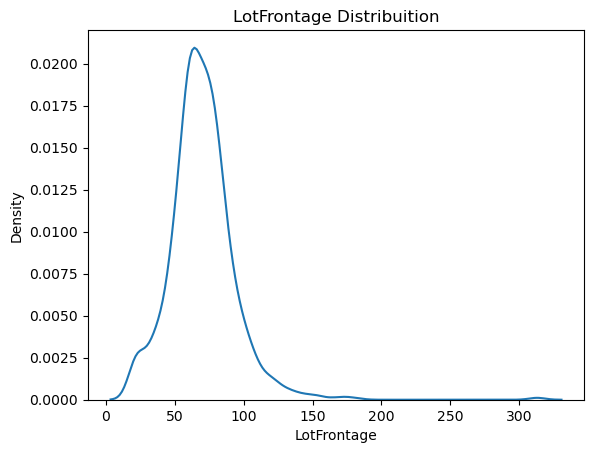

In [200]:
#Plot the  kernel density estimation of the LotFrontage variable
sns.kdeplot(subset, x='LotFrontage')
plt.title('LotFrontage Distribuition')
plt.show()

In [201]:
#Calculate the Skewness
skew = subset['LotFrontage'].skew()
print(f"Skewness: {skew}")

Skewness: 2.163569142324884


The LotFrontage variable presents a right-skewed distribution, skewness = +2.4. The imputation of the missing values will be handle using the median.

In [203]:
print(f"Number of missing values before imputation: {subset['LotFrontage'].isna().sum()}")

Number of missing values before imputation: 259


In [204]:
#Replace the missing values with the median
subset['LotFrontage'].fillna(subset['LotFrontage'].median(), inplace=True)

In [205]:
print(f"Number of missing values after imputation: {subset['LotFrontage'].isna().sum()}")

Number of missing values after imputation: 0


---

#### 4- Handling Categorical Data

4.1- Split categorical feature into a `df_categorical` dataframe

In [209]:
df_categorical = subset.select_dtypes(include='object') #Uses the select_dtypes method to get only the object type columns.
df_categorical.head(5)

,SaleType,SaleCondition
0,WD,Normal
1,WD,Normal
2,WD,Normal
3,WD,Abnorml
4,WD,Normal


4.2- Apply OHE to `SaleType`

In [211]:
ohe_encoder = OHE(use_cat_names=True) #Creates an object of the class category_encoders.one_hot.OneHotEncoder, uses the category value in the column name.
ohe_df = ohe_encoder.fit_transform(df_categorical[['SaleType']]) #Apply the one hot enconding to the SaleType column.
ohe_df.head()

,SaleType_WD,SaleType_New,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_Oth
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0


---

#### 5- Feature Scaling

5.1- Apply feature scaling to the variable `GarageArea`. Make sure that the new range fall between `-1/3` and `3`.

In [215]:
df_garageArea = subset[['GarageArea']] #Creates a new dataframe with only the GarageArea column.

In [216]:
#Creates an object of the type MinMaxScaler and sets the range between -1/3 and 3.
mmscaler = MinMaxScaler(feature_range=(-1/3, 3))

#Creates a new column named normalization that contains the scaled feature GarageArea.
df_garageArea['normalization'] = mmscaler.fit_transform(df_garageArea[['GarageArea']])

df_garageArea.head()

,GarageArea,normalization
0,548,0.954866
1,460,0.748002
2,608,1.095910
3,642,1.175835
4,836,1.631876


In [217]:
print(f'normalizaiton min: {df_garageArea.normalization.min()}, normalizaiton max: {df_garageArea.normalization.max()}')

normalizaiton min: -0.3333333333333333, normalizaiton max: 3.0


As expected the minimum is -1/3 and the maximum is 3.

---

---

## Part 2

Since the SalePrice column will not be used during the rest of the project the first step is to replace this column with the target.

In [223]:
df['target'] = subset['target'] #Adds the target column to the full dataframe.
df.drop('SalePrice', axis=1, inplace=True) #Eliminates the SalePrice column.

In [224]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,target
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,1


### Missing Values

In [226]:
#Percentage of missing values in each column.
null_total = 100*df.isna().sum()/len(df)

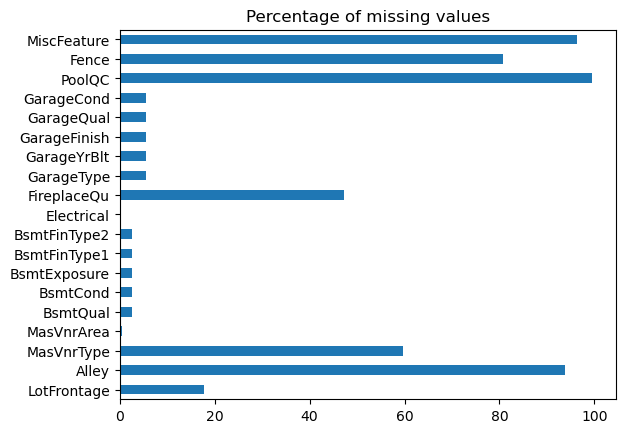

In [227]:
#PLots, for the columns that have missing values, the correspondent percentage.
null_total[null_total>0].plot(kind='barh', title="Percentage of missing values")
plt.show()

The plot shows the percentage of missing values for each column, however most of them are not actually missing values.
The missing values can be explained by other variables, missing at random, or by themselves, missing not at random.<br>
Before handle the missing values, the data needs to be divided into training and testing.

### Split the Data into train and test

In [230]:
train_df, test_df = split_dataset(df, 'target') #Splits the dataset into two dataframes, one for training and one for testing.

### Handling Missing Values

##### MiscFeature

The MiscFeature variable is related to the MiscVal, when the MiscVal=0 the MiscFeature is missing.

In [234]:
#Gets the count of unique values for the MiscVal when the MiscFeature is missing.
print(train_df[train_df['MiscFeature'].isna()]['MiscVal'].value_counts())
print(test_df[test_df['MiscFeature'].isna()]['MiscVal'].value_counts())

MiscVal
0    940
Name: count, dtype: int64
MiscVal
0    466
Name: count, dtype: int64


As we can see, for the training and testing data, when the MiscFeature is missing the MiscVal is always 0.<br>
For both datasets, i am going to impute the missing values with a new category named NA.

In [236]:
train_df['MiscFeature'].fillna('NA', inplace=True) #Replace the missing value in the training data with 'NA'
test_df['MiscFeature'].fillna('NA', inplace=True) #Replace the missing value in the testing data with 'NA'

##### PoolQC

The PoolQC (Pool quality) is related with the PoolArea, if the PoolArea=0 there is no reason to assign a quality level to the pool.

In [239]:
#Gets the count of unique values for the PoolArea when the PoolQC is missing.
print(train_df[train_df['PoolQC'].isna()]['PoolArea'].value_counts())
print(test_df[test_df['PoolQC'].isna()]['PoolArea'].value_counts())

PoolArea
0    974
Name: count, dtype: int64
PoolArea
0    479
Name: count, dtype: int64


As expected when the PoolQC is missing it's because the pool area is 0.<br>
For both datasets, i am going to impute the missing values with a new category named NA.

In [241]:
train_df['PoolQC'].fillna('NA', inplace=True) #Replace the missing value in the training data with 'NA'
test_df['PoolQC'].fillna('NA', inplace=True) #Replace the missing value in the testing data with 'NA'

##### FireplaceQU

The FireplaceQu variable, just like MiscFeature and PoolQc variables, is directly related with the number of fireplaces (Fireplaces).

In [244]:
#Gets the count of unique values for the Fireplaces when the FireplaceQu is missing.
print(train_df[train_df['FireplaceQu'].isna()]['Fireplaces'].value_counts())
print(test_df[test_df['FireplaceQu'].isna()]['Fireplaces'].value_counts())

Fireplaces
0    456
Name: count, dtype: int64
Fireplaces
0    234
Name: count, dtype: int64


Once again, when the number of fireplaces is 0 the fireplace quality is missing. So, the missing values will be replaced with 'NA'.

In [246]:
train_df['FireplaceQu'].fillna('NA', inplace=True) #Replace the missing value in the training data with 'NA'
test_df['FireplaceQu'].fillna('NA', inplace=True) #Replace the missing value in the testing data with 'NA'

##### MasVnrType and MasVnrArea

In [248]:
#Gets the count of unique values for the MasVnrArea when the MasVnrType is missing.
print(train_df[train_df['MasVnrType'].isna()]['MasVnrArea'].value_counts())
print(test_df[test_df['MasVnrType'].isna()]['MasVnrArea'].value_counts())

MasVnrArea
0.0      567
1.0        2
288.0      1
312.0      1
344.0      1
Name: count, dtype: int64
MasVnrArea
0.0    292
Name: count, dtype: int64


For the Masonry veneer type, as expected, most of the missing values have a mansory veneer area of 0, which means that the values are missing because there is no mansory veneer, for this cases the null values will be replaced with 'NA'.<br>
For the cases where the MasVnrArea is different than 0, the missing values on the MasVnrType will be replaced with the mode of the training data.<br>
For the 8 cases of missing values in the MasVnrArea, let's assume that the lack of registration is due to the fact that there is no mansory veneer area. So for this cases i will replace with 0.

In [250]:
#Gets the mode of the training MasVnrType.
masvnrtype_mode = train_df['MasVnrType'].mode()[0]

#Locates the rows where the MasVnrType is null and MasVnrType is greater than 0, and sets the missing values with the mode.
train_df.loc[train_df['MasVnrType'].isna() & (train_df['MasVnrArea'] > 0), 'MasVnrType'] = masvnrtype_mode

In [251]:
#Replaces the rest of the missing values with 'NA'.
train_df['MasVnrType'].fillna('NA', inplace=True)
test_df['MasVnrType'].fillna('NA', inplace=True)

In [252]:
#Replaces the MasVnrArea missing values with 0.
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)

##### GarageCond, GarageQual, GarageFinish, GarageYrBlt and GarageType

The missing values for the garage associated variables are due to the fact that there is no garage on the house.<br>
For the categorical variables, GarageCond, GarageQual, GarageFinish and GarageType the missing values will be replaced with 'NA'.<br>
The GarageYrBlt will be replaced with 0.

In [255]:
#For loop to fill the GarageCond, GarageQual, GarageFinish, GarageType clomuns missing values in the training and testing data.
for column in ['GarageCond','GarageQual','GarageFinish','GarageType']:
    train_df[column].fillna('NA', inplace=True)
    test_df[column].fillna('NA', inplace=True)

#Fill the missing values for the GargeYrBlt on the training and testing data.
train_df['GarageYrBlt'].fillna(0, inplace=True)
test_df['GarageYrBlt'].fillna(0, inplace=True)

##### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2

For the basement related variables the missing values are explained by the absence of basement, so the null values will be replaced with 'NA'.<br>

In [258]:
print('Basement related variables missing values for the training data.')
train_df[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].isna().sum()

Basement related variables missing values for the training data.


BsmtQual        25
BsmtCond        25
BsmtExposure    26
BsmtFinType1    25
BsmtFinType2    26
dtype: int64

In [259]:
print('Barage related variables missing values for the testing data.')
test_df[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].isna().sum()

Barage related variables missing values for the testing data.


BsmtQual        12
BsmtCond        12
BsmtExposure    12
BsmtFinType1    12
BsmtFinType2    12
dtype: int64

In [260]:
#For loop to fill the BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 clomuns missing values in the training and testing data.
for column in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    train_df[column].fillna('NA', inplace=True)
    test_df[column].fillna('NA', inplace=True)

##### Alley and Fence

For the Alley and Fence variables, although they are not related to other variable, if we check the description file, we can see that the missing values is explained by the absence of alley and fence. That said, the missing values will be replaced by 'NA'.

In [263]:
#Fill the missing values for the Alley and Fence on the training data
train_df['Alley'].fillna('NA', inplace=True) 
train_df['Fence'].fillna('NA', inplace=True) 

#Fill the missing values for the Alley and Fence on the testing data
test_df['Alley'].fillna('NA', inplace=True) 
test_df['Fence'].fillna('NA', inplace=True) 

##### Electrical

The electrical system variable only has 1 missing value in the testing data, which will be replaced with the mode of the training data.

In [266]:
print(f"Training data missing values: {train_df['Electrical'].isna().sum()}")
print(f"Testing data missing values: {test_df['Electrical'].isna().sum()}")

Training data missing values: 0
Testing data missing values: 1


In [267]:
electrical_mode = train_df['Electrical'].mode()[0]
test_df['Electrical'].fillna(electrical_mode, inplace=True)

##### LotFrontage

For the LotFrontage variable, we cannot explain the missing values, probably the person that did the observation forgot to register the value or something happened.<br>
So, for this case, the missing values will be imputed using the median as shown in Part 1.

In [270]:
#Replaces the missing values with the median
train_df['LotFrontage'].fillna(train_df['LotFrontage'].median(), inplace=True)
test_df['LotFrontage'].fillna(test_df['LotFrontage'].median(), inplace=True)

### Choice of variables

In this part of the project, i will choose the variables that i am going to use from now on.<br>
The threshold that will be chosen is the correlation between the target variable, which is the one we are trying to predict, and the remaining ones. 

In [273]:
#Divide training data into numerical and categorical
numerical_train = train_df.select_dtypes(include='number')
categorical_train = train_df.select_dtypes(include='object')

#Add target variable to categorical_train
categorical_train['target'] = train_df['target']

#### Numerical variables

In [275]:
#Get correlation matrix from dataframe
correlation_matrix = numerical_train.corr().drop('target')

#Filter the correlation for target with the remaining features
target_corr = correlation_matrix[['target']]

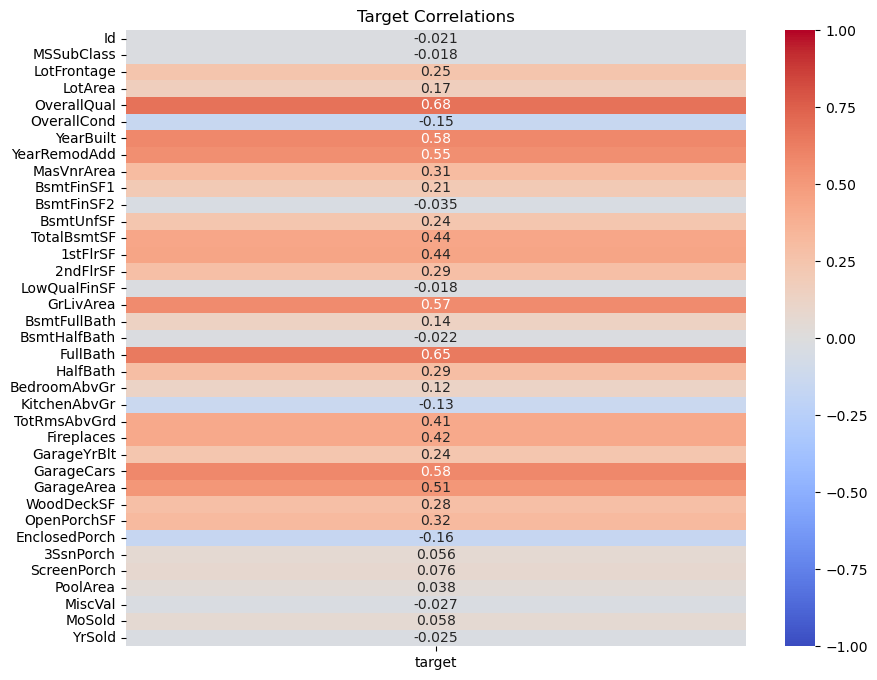

In [276]:
#Plot the correlation's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Target Correlations')
plt.show()

In [277]:
#Correlation bigger than 0.5
target_corr[target_corr['target']>0.5]

,target
OverallQual,0.676285
YearBuilt,0.583011
YearRemodAdd,0.552806
GrLivArea,0.568822
FullBath,0.646653
GarageCars,0.583722
GarageArea,0.507946


In [278]:
#Create a list of variables names with target correlation bigger than 0.5
numerical_features = target_corr[target_corr['target']>0.5].index.tolist()
#Add to numerical_feature the variable LotFrontage
numerical_features.append('LotFrontage')

As shown in the table above, the variables that have a correlation with the target variable bigger than 0.5, are OverallQual, YearBuilt, YearRemodAdd, GrLivArea, FullBath, GarageCars and GarageArea.<br>
The p_value values also demonstrates a significant statistical association between the variables.<br>
LotFrontage as a weak correlation with the target variable, but still has some statistical dependence. Although, this variable does not match the threshold defined, since it was chosen by default for the project i will keep it.

#### Categorical variables

For categorical variables, since i can't calculate de correlation, i will use the chi2_contingency method from the scipy.stats module.<br>
With the Chi-squared test for independence, i can test if there is a significant association between the categorical variable and the binary target.<br>
Instead of defining the p_value<0.05 as the threshold, as i usually would, for the purpose of the project i will pick the features with the 5 lowest p_values.

In [282]:
categorical_features = []
p_value_list = []

#Loop to calculate the statistics between categorical variables and target.
for col in categorical_train.drop('target', axis=1).columns:
    #Creates contigency table
    contingency_table = pd.crosstab(categorical_train[col], categorical_train['target']) 
    #Calculates the p_value
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    #Append the p_value to a list 
    p_value_list.append(p)  
    #Append the feature name to a list
    categorical_features.append(col)

#Create a dataframe where the indexes are the variables names and the values the p_value
temp_df = pd.DataFrame({'p_value': p_value_list}, index=categorical_features)
#Get the variable names of the 5 lowest p_values
temp_df.sort_values(by='p_value').head(5)

,p_value
Neighborhood,8.149573e-98
BsmtQual,1.553351e-86
KitchenQual,3.921314e-82
ExterQual,4.785808e-81
GarageFinish,4.538524e-76


In [283]:
#Get the variable names of the 5 lowest p_values
categorical_features = temp_df.sort_values(by='p_value').head(5).index.to_list()

#Add MasVnrType
categorical_features.append('MasVnrType')

As shown in the table above, the variables that have the 5 lowest p values are: Neighborhood, BsmtQual, KitchenQual, ExterQual, GarageFinish.<br>
Although, the MasVnrType feature doesn't fit into the threshold defined, i will keep it since it was chosen by default for the project.

In [285]:
#Filter the training and testing datasets with only the variables that are going to be used for the next part.
train_df_before_encode = train_df[numerical_features + categorical_features + ['target']]
test_df_before_encode = test_df[numerical_features + categorical_features + ['target']]

### Feature Engineering

In the real world one of the feature that is most correlated with the sale price of a house it's the total area.<br>
Due to this fact, i am going to add a new variable named TotalArea, which will be the sum of: first floor area (1stFlrSF), second floor area (2ndFlrSF), total basement area (TotalBsmtSF) and garage area (GarageArea).

In [288]:
#Add to the training data the new TotalArea variable
train_df_before_encode['TotalArea'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['TotalBsmtSF'] + train_df['GarageArea']
#Add to the testing data the new TotalArea variable
test_df_before_encode['TotalArea'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['TotalBsmtSF'] + test_df['GarageArea']

In [289]:
train_df_before_encode[['TotalArea', 'target']].corr()

,TotalArea,target
TotalArea,1.000000,0.625571
target,0.625571,1.000000


In [290]:
train_df_before_encode[['GarageArea', 'target']].corr()

,GarageArea,target
GarageArea,1.000000,0.507946
target,0.507946,1.000000


As expected, this new variable has a good correlation (~0.63) with the target variable.<br>
Since the garage area is already included in the total area and has a weaker correlation with the target, i will remove it from the data and just keep the TotalArea.

In [292]:
#Remove GarageArea from the training data
train_df_before_encode.drop('GarageArea', axis=1, inplace=True)
#Remove GarageArea from the testing data
test_df_before_encode.drop('GarageArea', axis=1, inplace=True)

### Handling Outliers

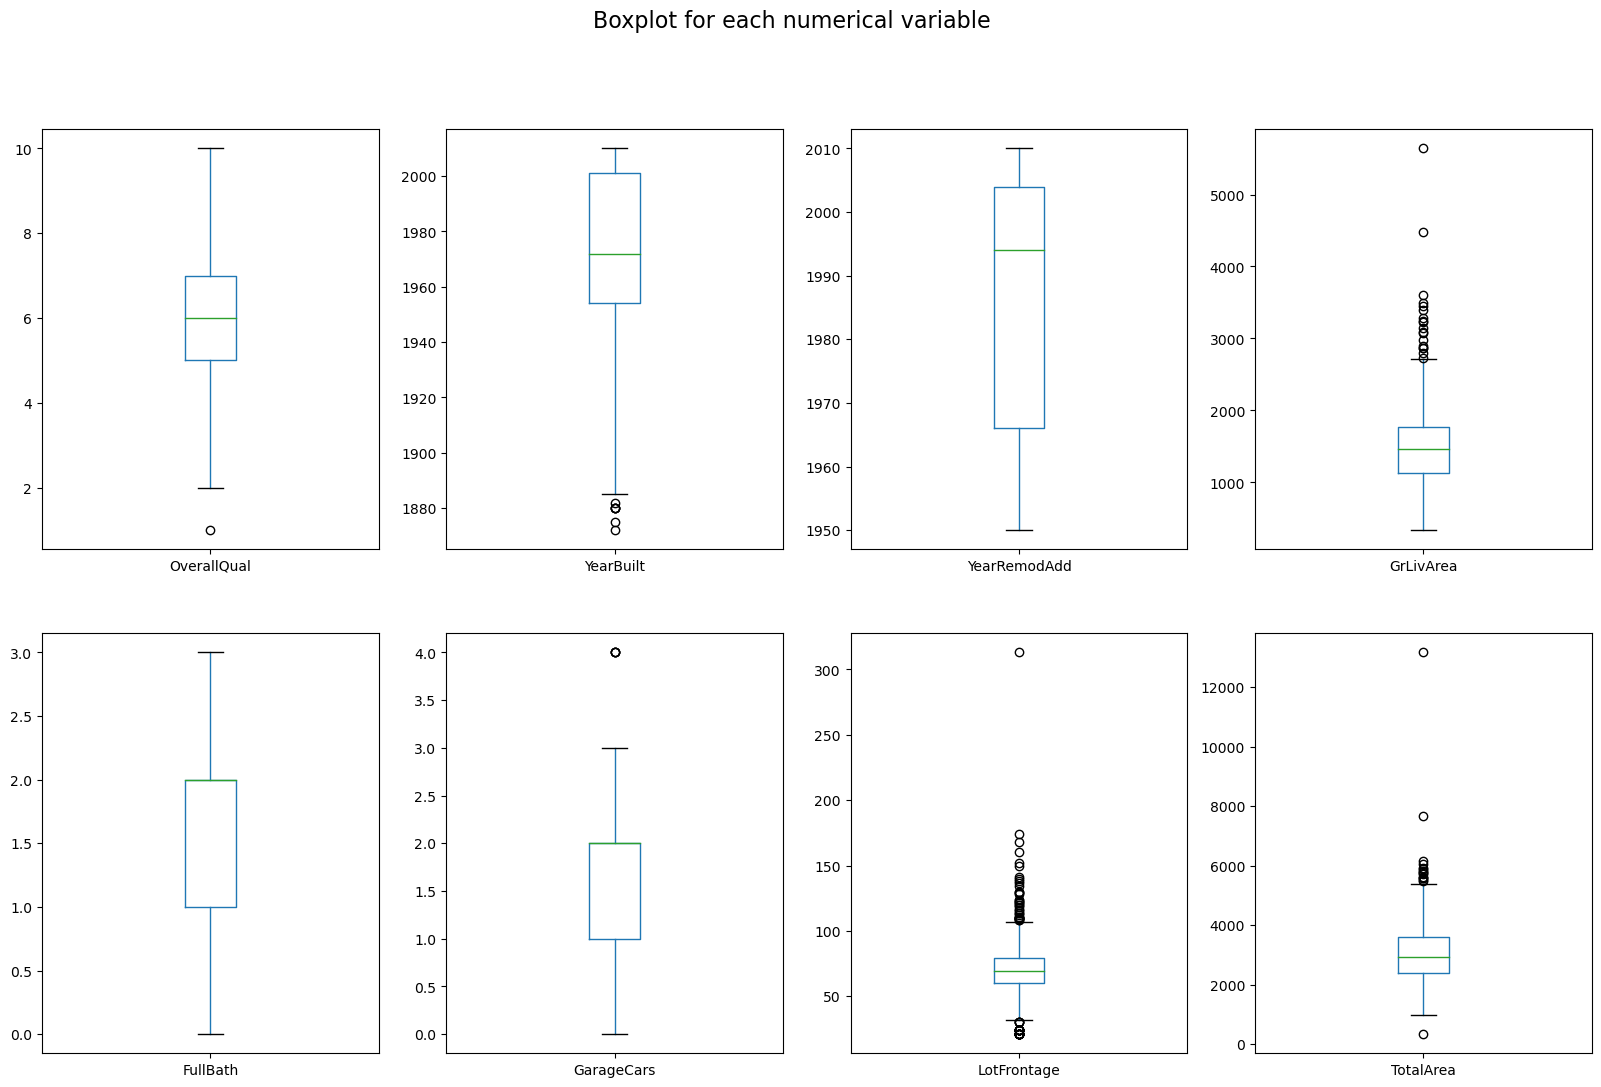

In [294]:
#Create a temporary dataframe with the numerical variables without the target
temp_df = train_df_before_encode.select_dtypes(include='number').drop('target', axis=1)

#Create a figure 2 rows, 4 columns with 8 plots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12))

#Loop to add the variables boxplots to each subplot
for i, col in enumerate(temp_df.columns):
    if i<4:
        temp_df.boxplot(column=col, ax=axes[0,i])  
        #Disable grid
        axes[0,i].grid(False)         
    else:
        i = i-4        
        temp_df.boxplot(column=col, ax=axes[1,i])  
        #Disable grid
        axes[1,i].grid(False)        

#Set the figure main title
fig.suptitle('Boxplot for each numerical variable', fontsize=16)
plt.tight_layout
plt.show()

As shown in the image above, the variables YearRemodAdd and FullBath don't have outliers. For the variables OverallQual and GarageCars, they only present one outlier with perfect normal value, so i will keep it.<br>
On the other hand, YearBuilt, GrLivArea, LotFrontage and TotalArea have a bigger number of outliers. Although they present real values, which means none of them takes negative or out of the scale values, i will still remove the extremes.<br>

Due to the fact, that the four variables have skewed distributions, i will use the quantile method to remove the extreme values.

In [296]:
#Columns to remove the outliers
columns_to_check = ['YearBuilt', 'GrLivArea', 'LotFrontage', 'TotalArea']

for col in columns_to_check:
    #Calculate 25th percentile
    q1 = train_df_before_encode[col].quantile(0.25)
    #Calculate 75th percentile
    q3 = train_df_before_encode[col].quantile(0.75)

    #Calculate interquantile range
    iqr = q3-q1

    #Define the lower bound for outliers
    lower_bound = q1 - 1.5 * iqr
    #Define the upper bound for outliers
    upper_bound = q3 + 1.5 * iqr

    #Filter out rows where the value in the column is outside the bounds
    train_df_before_encode = train_df_before_encode[(train_df_before_encode[col] >= lower_bound) & (train_df_before_encode[col] <= upper_bound)]
    test_df_before_encode = test_df_before_encode[(test_df_before_encode[col] >= lower_bound) & (test_df_before_encode[col] <= upper_bound)]

### Baseline Score

In [298]:
#Get the baseline score without any data transformation, only for the numerical values.
baseline_score = score_approach(train_df_before_encode.select_dtypes(include='number'), test_df_before_encode.select_dtypes(include='number'), 'target')
print(f'The baseline score for numerical feature without any transformation is: {baseline_score}')

The baseline score for numerical feature without any transformation is: 0.8796296296296297


#### Iteration #1

In [300]:
#Create new dataframe for econding
encoded_train = train_df_before_encode.copy()
encoded_test = test_df_before_encode.copy()

In the first iteration, i will apply one-hot encoding to all categorical features with cardinality<15 and without meaningful order, which in this case is only MasVnrType.<br>
MasVnrType variable, is one of the 3 features chosen by default for this project.

In [302]:
#Creates an object of the class OneHotEncoder.
ohe_encoder = OHE(use_cat_names=True)

In [303]:
#Fit the model with the training data.
ohe_encoder.fit(encoded_train[['MasVnrType']])

OneHotEncoder(cols=['MasVnrType'], use_cat_names=True)

In [304]:
#Transform the training and tsting data.
ohe_train = ohe_encoder.transform(encoded_train[['MasVnrType']])
ohe_test = ohe_encoder.transform(encoded_test[['MasVnrType']])

In [305]:
#Add the new encoded columns into encoded_train and encoded_test.
encoded_train = pd.concat([encoded_train, ohe_train], axis=1)
encoded_test = pd.concat([encoded_test, ohe_test], axis=1)

#Remove the previous columns, without the encoding.
encoded_train.drop('MasVnrType', axis=1, inplace=True)
encoded_test.drop('MasVnrType', axis=1, inplace=True)

In [306]:
#Calculate new score.
baseline_score_it1 = score_approach(encoded_train.select_dtypes(include='number'), encoded_test.select_dtypes(include='number'), 'target')
compare_scores(baseline_score, baseline_score_it1, 1)

Baseline score: 0.8796296296296297.
1 iteration score: 0.8796296296296297.
The baseline score remains the same: 0.8796296296296297.


#### Iteration #2

For the second iteration i will encode the variables that have a meaningful order, which mean they are ordinal.<br>
To do this, the best method is to apply an ordinal encoding. The columns to be encoded are: ExterQual, BsmtQual, KitchenQual and GarageFinish.

In [309]:
#Defines the list of ordinal columns that are going to be encoded
list_ordinal_colums = ['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish']

#Defines the ExterQual categories
exterqual_categories = ['Po','Fa', 'TA', 'Gd', 'Ex']
#Defines the BsmtQual categories
bsmtqual_categories = ['NA','Po','Fa', 'TA', 'Gd', 'Ex']
#Defines the KitchenQual categories
kitchenqual_categories = ['Po','Fa', 'TA', 'Gd', 'Ex']
#Defines the GarageFinish categories
garagefinish = ['NA', 'Unf', 'RFn', 'Fin']

In [310]:
#Creates an ordinal encoder with the defined categories
ord_encoder = OrdinalEncoder(categories=[exterqual_categories, bsmtqual_categories, kitchenqual_categories, garagefinish], dtype='int')

In [311]:
#Fits the model with the training data.
ord_encoder.fit(encoded_train[list_ordinal_colums])

OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                           ['NA', 'Unf', 'RFn', 'Fin']],
               dtype='int')

In [312]:
#Transforms the training data
ord_encoder_train = ord_encoder.transform(encoded_train[list_ordinal_colums])
#Transforms the testing data
ord_encoder_test = ord_encoder.transform(encoded_test[list_ordinal_colums])

In [313]:
for idx, col in enumerate(list_ordinal_colums):
    #Defines the new encoded column name
    new_column_name = col + '_enc'
    #Add to the training dataframe the new ordinal encoded values
    encoded_train[new_column_name] = ord_encoder_train[:,idx]
    #Add to the testing dataframe the new ordinal encoded values
    encoded_test[new_column_name] = ord_encoder_test[:,idx]

    #Removes the old column from the training data
    encoded_train.drop(col, axis=1, inplace=True)
    #Removes the old column from the testing data
    encoded_test.drop(col, axis=1, inplace=True)    

In [314]:
#Calculate new score.
baseline_score_it2 = score_approach(encoded_train.select_dtypes(include='number'), encoded_test.select_dtypes(include='number'), 'target')
compare_scores(baseline_score_it1, baseline_score_it2, 2)

Baseline score: 0.8796296296296297.
2 iteration score: 0.8981481481481481.
The 2 iteration score is the new baseline score 0.8981481481481481.


#### Iteration #3

Neighborhood is the only remaining categorical variable, it has 25 unique values which means a cardinality>15.<br>
Due to the fact that this variable as big cardinality and a high statistical relationship with the target, the method chosen to encode was the target encoding. 

In [317]:
#Instantiate the target encoder
target_encoder = ce.TargetEncoder(cols=['Neighborhood'])

In [318]:
#Fit the encoder with the training data.
target_encoder.fit(encoded_train['Neighborhood'], encoded_train['target'])

TargetEncoder(cols=['Neighborhood'])

In [319]:
#Transform the training data
target_train_df = target_encoder.transform(encoded_train['Neighborhood'], encoded_train['target'])
#Transform the testing data
target_test_df = target_encoder.transform(encoded_test['Neighborhood'], encoded_test['target'])

In [320]:
#Create a new column in the training dataframe for the Neighborhood encoded
encoded_train['Neighborhood_enc'] = target_train_df['Neighborhood']
#Create a new column in the testing dataframe for the Neighborhood encoded
encoded_test['Neighborhood_enc'] = target_test_df['Neighborhood']

#Remove from the training dataframe the old Neighborhood column
encoded_train.drop('Neighborhood', axis=1, inplace=True)
#Remove from the testing dataframe the old Neighborhood column
encoded_test.drop('Neighborhood', axis=1, inplace=True)

In [321]:
#Calculate new score.
baseline_score_it3 = score_approach(encoded_train.select_dtypes(include='number'), encoded_test.select_dtypes(include='number'), 'target')
compare_scores(baseline_score_it2, baseline_score_it3, 3)

Baseline score: 0.8981481481481481.
3 iteration score: 0.875.
The baseline score remains the same: 0.8981481481481481.


#### Iteration #4

For the variables YearBuilt and YearRemodAdd, since they are ordinal temporal variables, i will use binning to categorize the years into ranges.<br>
Since both features have skewed distribuitions i will use binning with quantile strategy.

In [324]:
#Instantiate the discretizer and define the number of bins
disc_quantile_estimator = KBinsDiscretizer(n_bins=[4,4], encode='ordinal', strategy='quantile')

In [325]:
#Fit the model with training data
disc_quantile_estimator.fit(encoded_train[['YearBuilt', 'YearRemodAdd']])

KBinsDiscretizer(encode='ordinal', n_bins=[4, 4])

In [326]:
#Show the bin edges
disc_quantile_estimator.bin_edges_

array([array([1885., 1953., 1972., 2000., 2010.]),
       array([1950., 1965., 1993., 2004., 2010.])], dtype=object)

In [327]:
#Transform the training data
results_train = disc_quantile_estimator.transform(encoded_train[['YearBuilt', 'YearRemodAdd']])
#Transform the testing data
results_test = disc_quantile_estimator.transform(encoded_test[['YearBuilt', 'YearRemodAdd']])

In [328]:
#Add the new values to the column on training data
encoded_train['YearBuilt'] = results_train[:,0]
encoded_train['YearRemodAdd'] = results_train[:,1]

#Add the new values to the column on testing data
encoded_test['YearBuilt'] = results_test[:,0]
encoded_test['YearRemodAdd'] = results_test[:,1]

In [329]:
#Calculate new score.
baseline_score_it4 = score_approach(encoded_train.select_dtypes(include='number'), encoded_test.select_dtypes(include='number'), 'target')
compare_scores(baseline_score_it2, baseline_score_it4, 4)

Baseline score: 0.8981481481481481.
4 iteration score: 0.8587962962962963.
The baseline score remains the same: 0.8981481481481481.


#### Iteration #5

For the GrLiveArea, since it follows a Non-Gaussian Distribution, i will apply normalization with Min-Max Scaling.

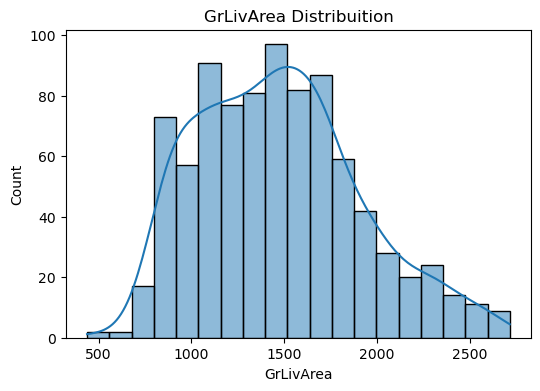

In [332]:
plt.figure(figsize=(6, 4))
sns.histplot(encoded_train['GrLivArea'], kde=True)
plt.title('GrLivArea Distribuition')
plt.show()

In [333]:
#Instantiate the min max scaler and define the range between -1,1
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

In [334]:
#Fit the model with training data
min_max_scaler.fit(encoded_train[['GrLivArea']])

MinMaxScaler(feature_range=(-1, 1))

In [335]:
#Transform the training data
results_train = min_max_scaler.transform(encoded_train[['GrLivArea']])
#Transform the testing data
results_test = min_max_scaler.transform(encoded_test[['GrLivArea']])

In [336]:
#Add the new values to the training dataframe
encoded_train['GrLivArea'] = results_train
#Add the new values to the testing dataframe
encoded_test['GrLivArea'] = results_test

In [337]:
#Calculate new score.
baseline_score_it5 = score_approach(encoded_train.select_dtypes(include='number'), encoded_test.select_dtypes(include='number'), 'target')
compare_scores(baseline_score_it2, baseline_score_it5, 5)

Baseline score: 0.8981481481481481.
5 iteration score: 0.8657407407407407.
The baseline score remains the same: 0.8981481481481481.


#### Iteration #6

For the LotFrontage and TotalArea, I will assume that the distribution approximately follows the Gaussian Distribution and apply Standardization.

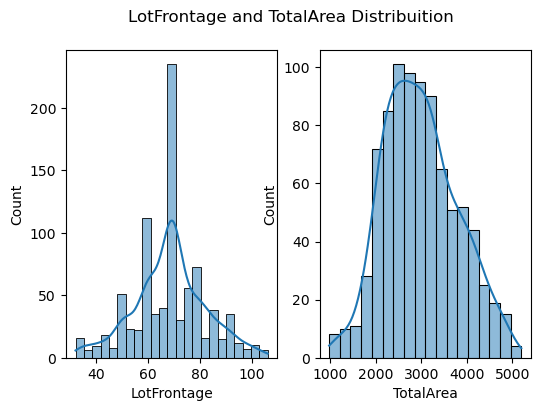

In [340]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))
sns.histplot(encoded_train['LotFrontage'], kde=True, ax=axes[0])
sns.histplot(encoded_train['TotalArea'], kde=True, ax=axes[1])
fig.suptitle('LotFrontage and TotalArea Distribuition')
plt.show()

In [341]:
#Instantiate the StandardScaler and define the range between -1,1
zscore = StandardScaler()

In [342]:
#Fit the model with training data
zscore.fit(encoded_train[['LotFrontage', 'TotalArea']])

StandardScaler()

In [343]:
#Transform the training data
results_train = zscore.transform(encoded_train[['LotFrontage', 'TotalArea']])
#Transform the esting data
results_test = zscore.transform(encoded_test[['LotFrontage', 'TotalArea']])

In [344]:
#Add the new values to the training dataframe
encoded_train['LotFrontage'] = results_train[:,0]
encoded_train['TotalArea'] = results_train[:,1]
#Add the new values to the testing dataframe
encoded_test['LotFrontage'] = results_test[:,0]
encoded_test['TotalArea'] = results_test[:,1]

In [345]:
#Calculate new score.
baseline_score_it6 = score_approach(encoded_train, encoded_test, 'target')
compare_scores(baseline_score_it2, baseline_score_it6, 6)

Baseline score: 0.8981481481481481.
6 iteration score: 0.8726851851851852.
The baseline score remains the same: 0.8981481481481481.


### Results

In [347]:
#List of iteration results
list_of_results = [baseline_score,
                   baseline_score_it1,
                   baseline_score_it2,
                   baseline_score_it3,
                   baseline_score_it4,
                   baseline_score_it5,
                   baseline_score_it6]

#Create dataframe os scores
results_pd = pd.DataFrame(list_of_results, columns=['Score'])

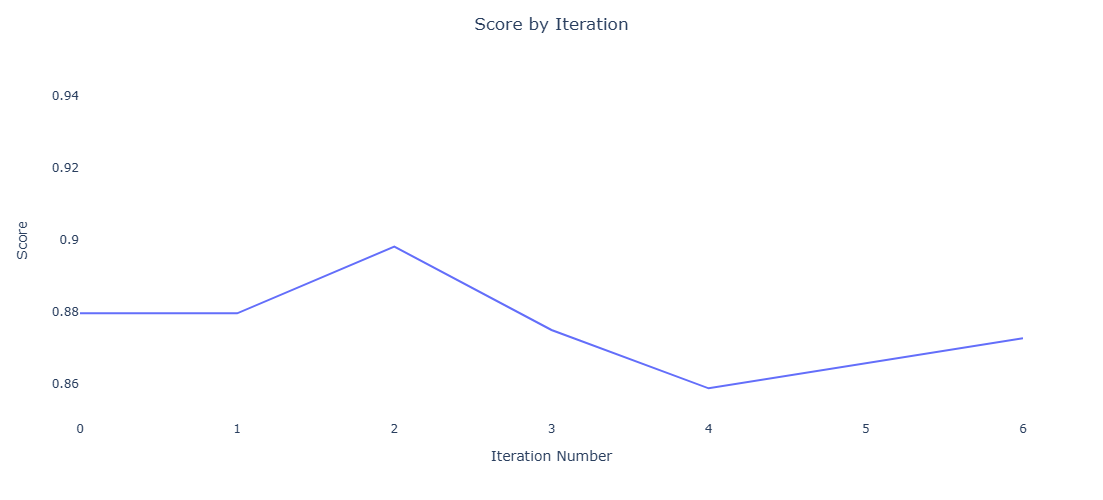

In [348]:
#PLots a line plot with the results using plotly
fig = px.line(results_pd, x=results_pd.index, y="Score")

fig.update_layout(height=500,                  
                  plot_bgcolor = 'white',
                  paper_bgcolor = 'white',
                  title = f'Score by Iteration',
                  title_x=0.5,
                  xaxis_title='Iteration Number', 
                  yaxis_title='Score',                   
                  hovermode="x unified"
                  )

fig.update_yaxes(range=[0.85, 0.95])
fig.update_traces(hovertemplate='Iteration: %{x}<br>Score: %{y}')
fig.show()

Although the variation in scores is small, showing a top score of ~0.9 in iteration 2 and a bottom score of ~0.86 in iteration 4, we can see that the choice of methods for pre-processing data is important for the model's performance.<br>
In iteration 4, the low score can be explained with the binning of the YearBuilt and YearRemodAdd, although this method simplifies the data and increases computational performance, it removes a lot of information especially if the variable has a strong relationship with the target.<br>

Points to keep in mind for future projects:
* Understand the dataset
* Try to understand where the missing values are coming from
* Understand the relation between variables and choose the best ones
* Choose the appropriate methods for each variable encoding